本次為愛荷華州艾姆斯共2930間房屋數據，透過房屋特徵、位置、地區消息、屋況、屋齡等特徵
來對於'房屋售價'進行分析來進行'房價預測'。

In [1]:
%matplotlib inline

In [2]:
#以提高jupyter notebook圖形顯示的解析度
%config InlineBackend. figure_format = 'retina'

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
fig = plt.figure()
sns.set()

<Figure size 640x480 with 0 Axes>

In [5]:
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

In [6]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
#瀏覽特徵字段
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

建物面積：1stFlrSF(一樓面積)、GrLivArea(一樓以上總生活空間)、TotalBsmtSF(地下室總面積)等。

裝置數量：FullBath、Kitchen、Bedroom數量。

量表型類別特徵：ExterCond(外部狀態)、ExterQual(外觀材質)、GarageQual(車庫品質)等，這類型特徵的值為Excellent/Good/Averege/Fair/Poor等具有順序特性。

一般類別特徵：Neighborhood(所在區域)、HouseStyle(房屋型式)等

日期相關特徵：YrSold(售出年度)、MoSold(售出月份)、GarageYrBlt(車庫建造年度)等。

In [8]:
#遺漏值
train_df.isna().sum()

#最多的為LotFrontage(直線距離)

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [9]:
#判別型態
train_df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

In [10]:
#.看看'SalePrice'標籤的分佈情況
train_df['SalePrice'].describe()

#房價平均18萬，最小3萬，最大75萬

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Count'>

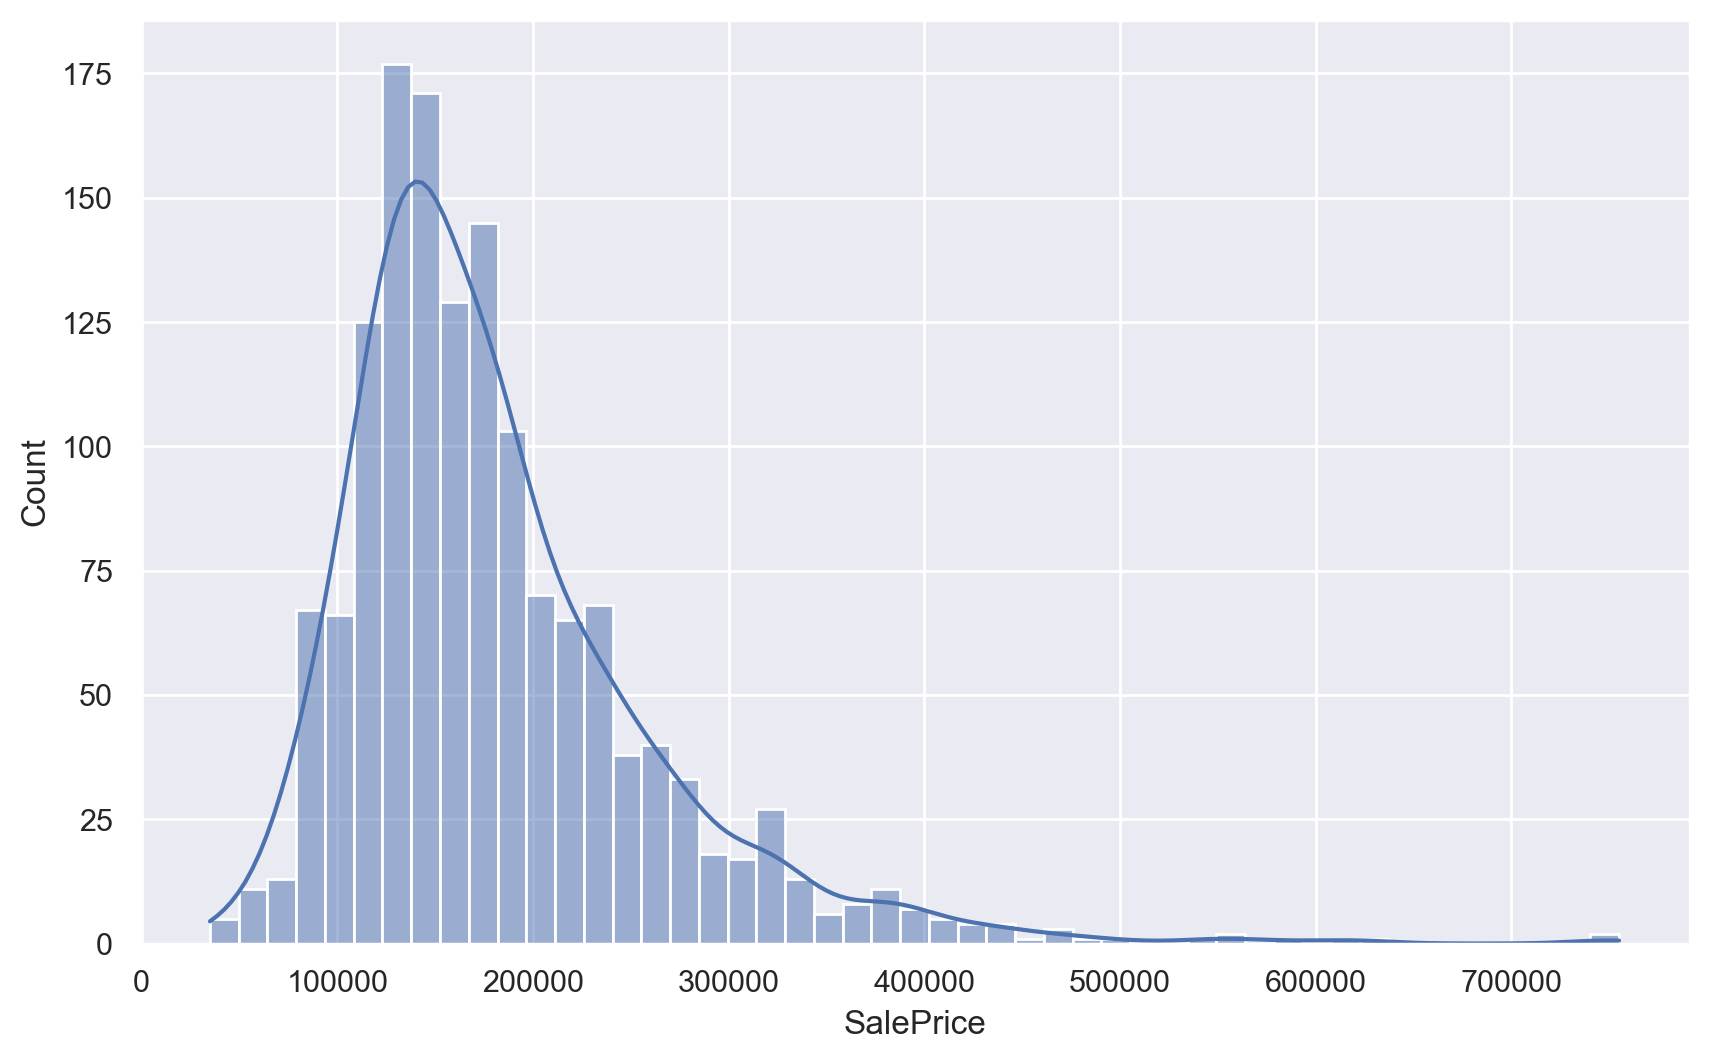

In [11]:
#對於預測結果"SalePrice"進行可視化
plt.figure(figsize=(10,6))
sns.histplot(train_df.SalePrice, kde=True)

C:\Users\znzn8\AppData\Local\Temp\ipykernel_101268\752142169.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cols = train_df.corr().nlargest(10, 'SalePrice')['SalePrice'].index


<Axes: >

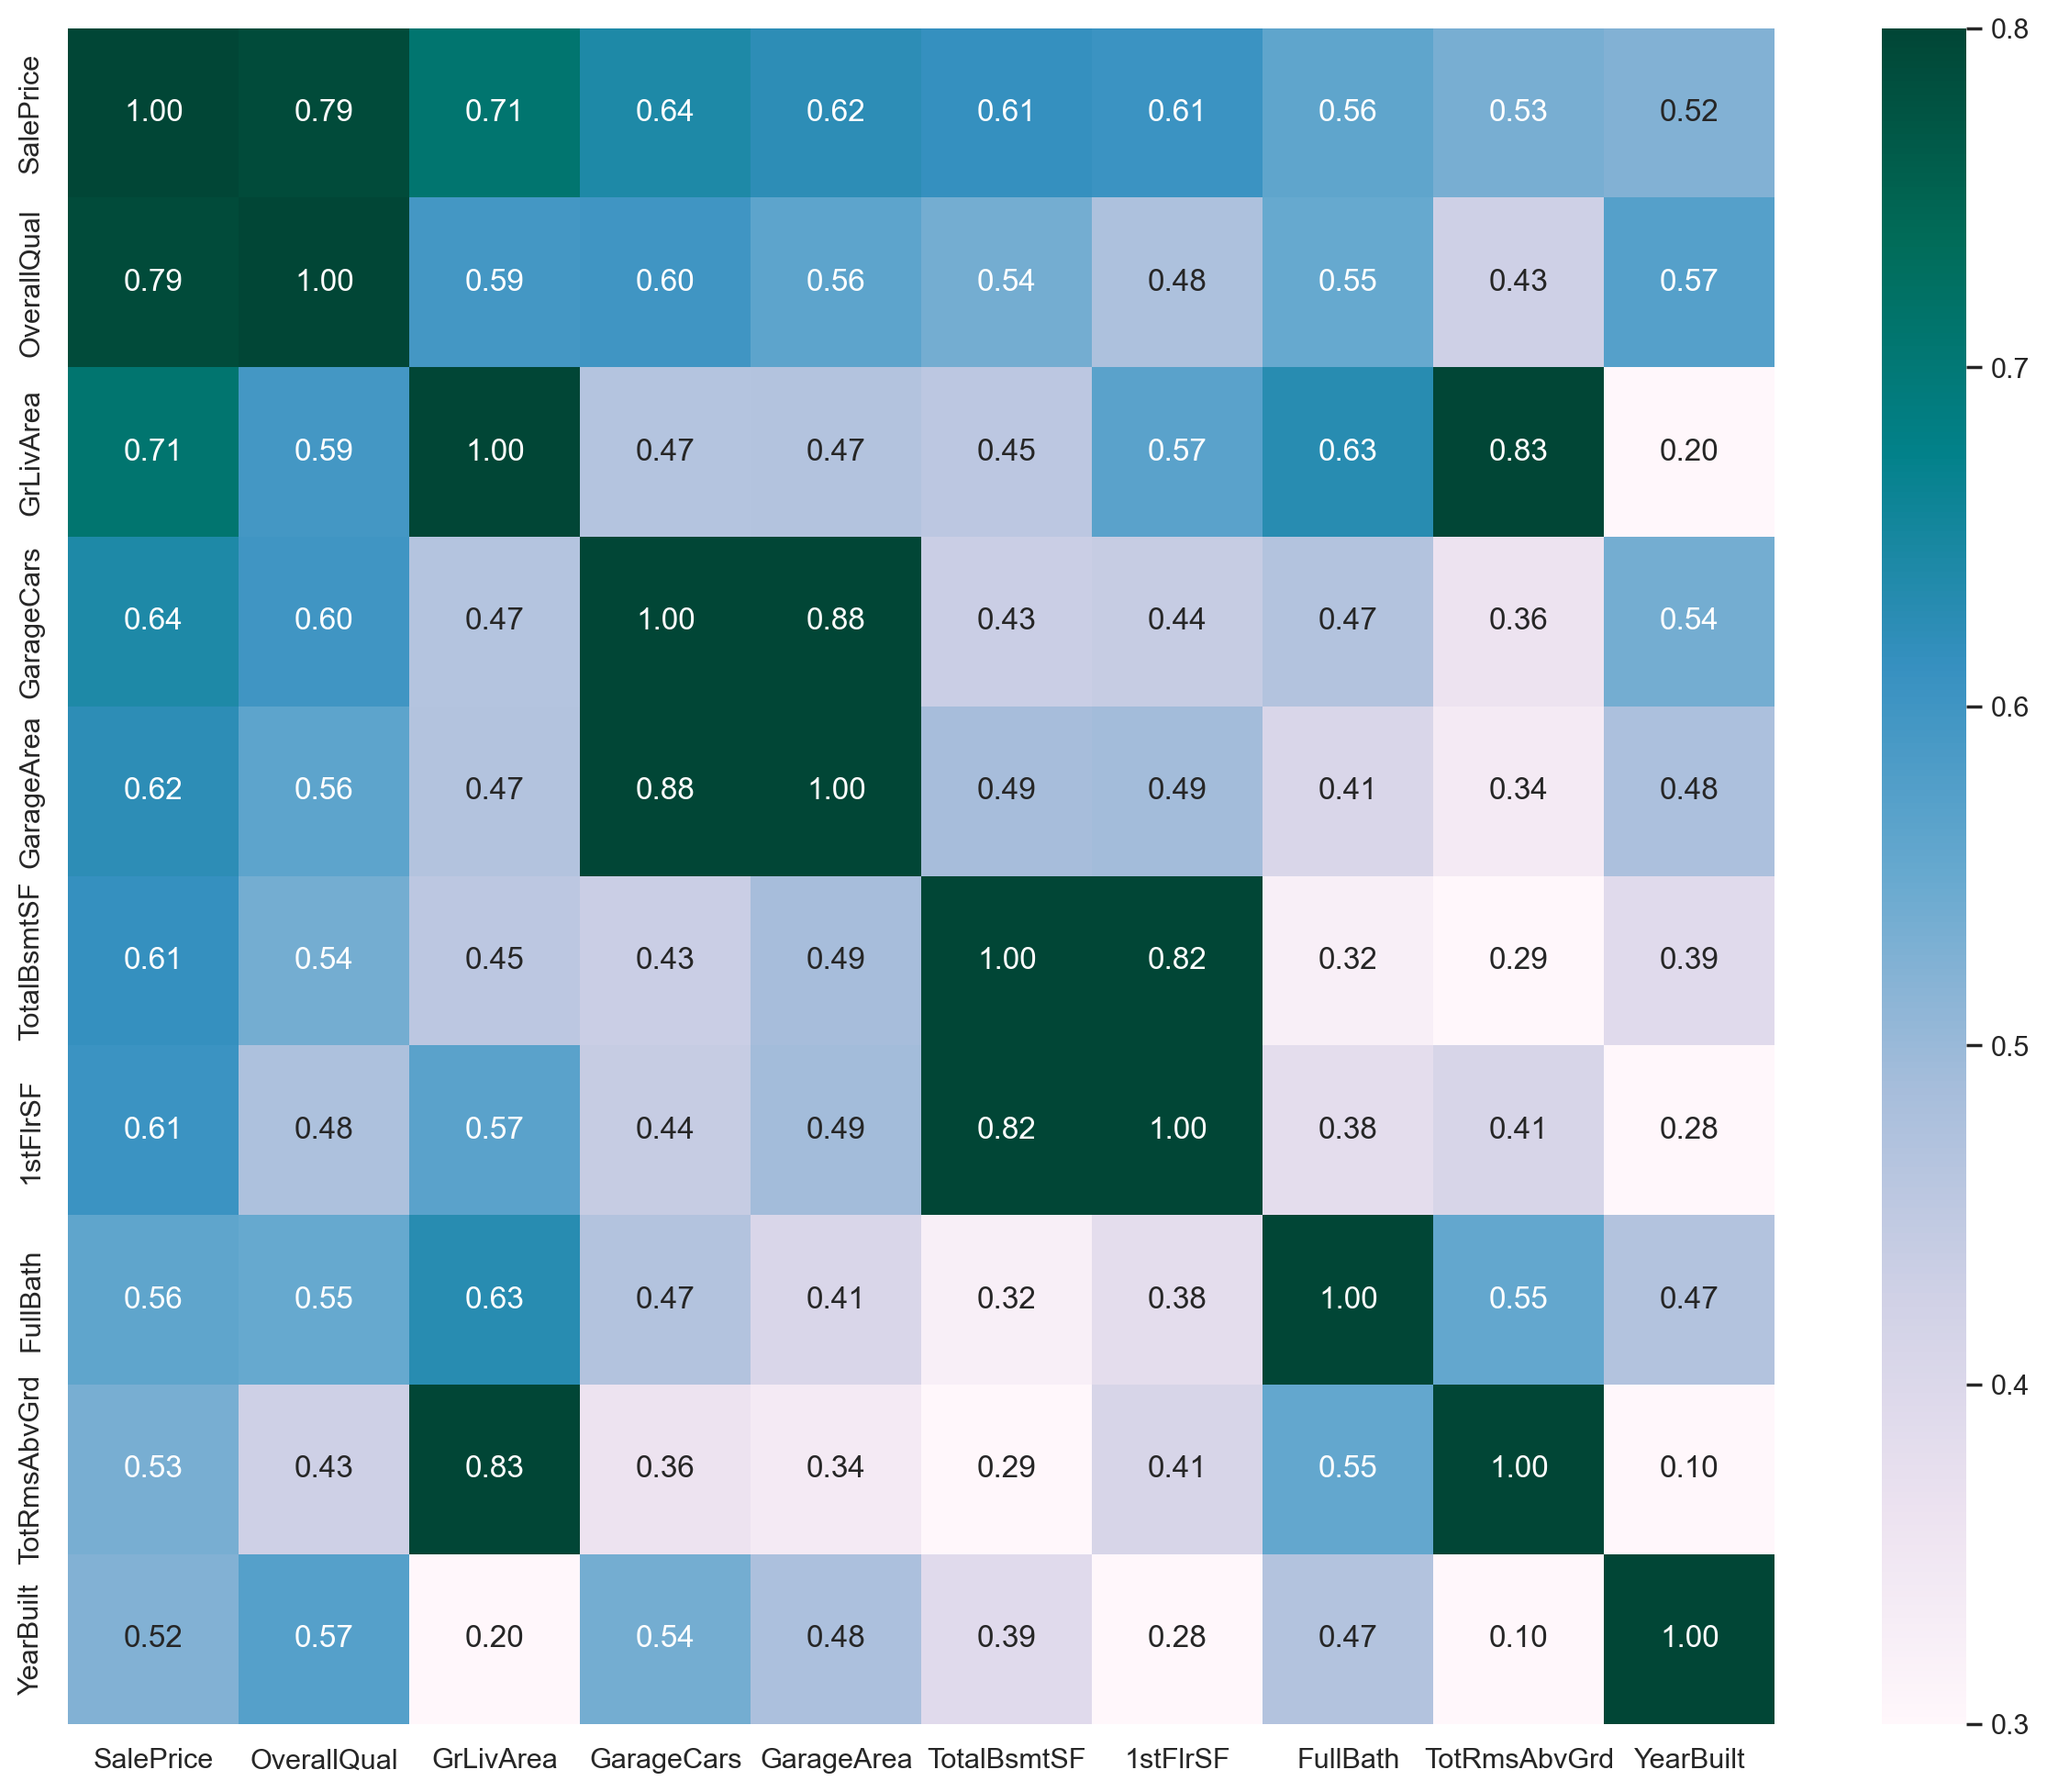

In [12]:
#如何選擇特徵？看相關係數 (70筆資料取10筆)
cols = train_df.corr().nlargest(10, 'SalePrice')['SalePrice'].index

cm = np.corrcoef(train_df[cols].values.T)

fig = plt.figure(figsize=(15,12))

sns.heatmap(cm, vmin=0.3, vmax=0.8, annot=True, fmt='.2f', yticklabels=cols.values, xticklabels=cols.values, cmap='PuBuGn')

In [60]:
#得出前10個相關性的特徵
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

In [ ]:
~~

In [ ]:
~~

In [13]:
#第二個方法，利用所有特徵來訓練
#聯合數據
all_df = pd.concat((train_df, test_df), axis=0)
all_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [14]:
all_df.shape

(2919, 80)

In [15]:
#One-hot處理
#注意到MSSubClass_20是類別型數據
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [16]:
pd.get_dummies(all_df['MSSubClass'], prefix='MSSubClass').head()

,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [21]:
#MSSSubClass 被我們分成了12個column ,每一個代表一個Category, 是就是1，不是就是0。
#同樣，將所有的category數據，都給One-Hot
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.tail()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2919,60,74.0,9627,7,5,1993,1994,94.0,758.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
~~

In [ ]:
~~

In [27]:
#看看還有多少缺失值，數值型的數據還存在缺失值
all_dummy_df.isna().sum()

#缺失值最多的是LotFrontage :Linear feet of street connected to property
#意思是與街道的直線距離，GarageYrBlt ：車庫修建年份

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 289, dtype: int64

In [25]:
#採用各特徵已有數據的平均值來填充
mean_cols = all_dummy_df.mean()
mean_cols.head(10)

MSSubClass         57.137718
LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
dtype: float64

In [26]:
#使用fillna()補充
all_dummy_df = all_dummy_df.fillna(mean_cols)

In [28]:
all_dummy_df.isna().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 289, dtype: int64